In [5]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision.models import resnet50
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report

## Preprocessing dataset

In [6]:
def get_year(x):
  if '/' in x:
    return int(x.split('/')[-1])
  elif '-' in x:
    return int(x.split('-')[-1])

In [7]:
# Clinical csv

clinical_annotation = pd.read_csv("/content/drive/MyDrive/MVA/DLMI/dlmi-lymphocytosis-classification/clinical_annotation.csv", index_col=1)
clinical_annotation.drop(clinical_annotation.columns[0], axis=1, inplace=True)

# Preprocessing on structured data
dict_to_encode = {'M': 0, "F":1, "f":1}
clinical_annotation.head()
clinical_annotation['GENDER'] = clinical_annotation['GENDER'].replace(dict_to_encode).astype(float)
clinical_annotation['YEAR'] = clinical_annotation['DOB'].apply(get_year)
clinical_annotation['AGE'] = 2023 - clinical_annotation['YEAR']
clinical_annotation.drop(['DOB', 'YEAR'], axis=1, inplace=True)
df_test = clinical_annotation[clinical_annotation['LABEL'] == -1]
df_train = clinical_annotation[clinical_annotation['LABEL'] != -1]
target = df_train['LABEL']
target_test = df_test['LABEL']
df_train.drop(['LABEL'], axis=1, inplace=True)
df_test.drop(['LABEL'], axis=1, inplace=True)
clinical_annotation.head()
df_train.dtypes

<ipython-input-7-bddbba84a4d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['LABEL'], axis=1, inplace=True)
<ipython-input-7-bddbba84a4d5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['LABEL'], axis=1, inplace=True)


GENDER         float64
LYMPH_COUNT    float64
AGE              int64
dtype: object

In [ ]:
# Function to reduce the size of the image
## TO ADJUST : Default : 112 * 112 but can be reduced by adding con2d with stride = 2 ##
def downsample_2d(X):
    # Assumant X a la forme [batch_size, channels, height, width]
    if X.dim() == 3:
        X = X.unsqueeze(0)
    channels = X.shape[1]
    kernel = torch.ones((channels, 1, 3, 3)) / 9.0  # Un noyau de lissage simple
    X = F.conv2d(X, kernel, groups=channels, stride=2, padding=1)
    X = X.squeeze(0)
    return X

In [ ]:
# Image Dataset for the pre training of the feature extractor

class ImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the patient folders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        patients = [os.path.join(root_dir, name) for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

        for patient_folder in patients:
            for image_file in os.listdir(patient_folder):
                full_path = os.path.join(patient_folder, image_file)
                if os.path.isfile(full_path):
                    self.image_paths.append(full_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        #print(image.size)
        if self.transform:
            image = self.transform(image)
            #print(image.shape)
            image = downsample_2d(image)

        return image

137
45
8
clinical infos tensor([[  0.0000,  64.8600,  65.0000],
        [  1.0000,   6.9800,  78.0000],
        [  1.0000, 217.5900,  59.0000],
        [  1.0000,   5.8900,  85.0000],
        [  1.0000,  15.4300,  91.0000],
        [  0.0000,   5.3900,  44.0000],
        [  1.0000,   6.5300,  91.0000],
        [  0.0000,   7.6800,  39.0000]])
label tensor([-1., -1., -1., -1., -1., -1., -1., -1.])


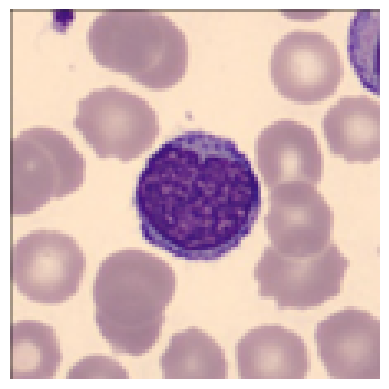

In [51]:
class PatientImagesDataset(Dataset):
    def __init__(self, root_dir, clinical_data, labels, transform=None):
        """
        Args:
            root_dir (string): Directory with all the patient folders.
            patient_id (list of str) : To distinguish between train and valid
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir

        self.clinical_data = clinical_data
        self.transform = transform
        self.patients = [os.path.join(root_dir, name) for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]

        self.labels = labels

    def __len__(self):
        return len(self.patients)


    def __getitem__(self, idx):
            patient_folder = self.patients[idx]
            patient_id = os.path.basename(patient_folder)
            image_files = [os.path.join(patient_folder, name) for name in os.listdir(patient_folder) ]
            images = []
            for image_file in image_files:
                # Load the image
                image = Image.open(image_file).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                    image = downsample_2d(image, size=56)

                images.append(image)

            # Get clinical data for this patient
            clinical_info = self.clinical_data.loc[patient_id].values
            clinical_info = torch.tensor(clinical_info, dtype=torch.float)
            label = self.labels.loc[patient_id]
            label = torch.tensor(label, dtype=torch.float)

            return images, clinical_info,label


# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

# Function to deal with folders of different size per patient
def custom_collate_fn(batch):
    images = [item[0] for item in batch]# This will be a list of tensors
    clinical_infos = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return images, clinical_infos, labels
dataset = PatientImagesDataset('/content/drive/MyDrive/MVA/DLMI/dlmi-lymphocytosis-classification/testset', df_test, target_test, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)


# To see if everything work well
for sample in dataloader:
    img = sample[0][0]
    print(len(img))

    img = sample[0][1]
    print(len(img))
    print(len(sample[0]))
    print('clinical infos', sample[1])
    print("label", sample[2])
    img = img[0].squeeze(0).numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')  # Remove axes for better visual appearance
    plt.show()
    break

In [ ]:
df_test

,GENDER,LYMPH_COUNT,AGE
ID,,,
P71,0.0,5.76,77
P16,0.0,32.00,83
P114,0.0,4.60,94
P170,0.0,4.80,90
P98,1.0,6.24,53
P69,0.0,7.47,44
P92,1.0,55.26,76
P132,0.0,24.70,78
P81,0.0,64.86,65


In [52]:
# Batch size for the training of the final model 
### TO ADJUST ###
batch_size = 8 


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = PatientImagesDataset(
    root_dir='/content/drive/MyDrive/MVA/DLMI/dlmi-lymphocytosis-classification/trainset',
    clinical_data=df_train, labels=target,
    transform=transform
)


# Définissez la proportion ou le nombre absolu d'échantillons pour l'ensemble de validation
valid_size = 0.2  # Pour une division 80% train, 20% valid

# Calculez les tailles des ensembles d'entraînement et de validation
num_samples = len(dataset)
num_valid = int(num_samples * valid_size)
num_train = num_samples - num_valid

# Séparez le jeu de données en sous-ensembles d'entraînement et de validation
dataset_train, dataset_valid = random_split(dataset, [num_train, num_valid])

# Créez les DataLoaders pour les ensembles d'entraînement et de validation
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)



# Calculer le nombre de batches dans le DataLoader d'entraînement
num_batches_train = len(dataloader_train)
print(f'Nombre de batches dans le DataLoader d\'entraînement: {num_batches_train}')

# Calculer le nombre de batches dans le DataLoader de validation
num_batches_valid = len(dataloader_valid)
print(f'Nombre de batches dans le DataLoader de validation: {num_batches_valid}')

Nombre de batches dans le DataLoader d'entraînement: 17
Nombre de batches dans le DataLoader de validation: 4


In [10]:
#TEST
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset_test = PatientImagesDataset(
    root_dir='/content/drive/MyDrive/MVA/DLMI/dlmi-lymphocytosis-classification/testset',
    clinical_data=df_test, labels=target_test,
    transform=transform
)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

## Autoencoder feature extractor

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    ndf = 4  # number of feature maps
    nc = 3  # number of channels
    ## TO ADJUST ##
    emb_dim = 60
    ##############
    self.conv1 = nn.Conv2d(nc, ndf * 4, kernel_size=3, padding=1, stride=2)
    self.relu1 = nn.ReLU(True)
    self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)

    self.conv2 = nn.Conv2d(ndf *4, ndf * 8, kernel_size=3, padding=1, stride=1)
    self.relu2 = nn.ReLU(True)
    self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
    self.linear1 = nn.Linear(ndf * 8 * 14 * 14, emb_dim*3)
    self.linear2 = nn.Linear(emb_dim * 3, emb_dim)

  def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x, indices1 = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x, indices2 = self.pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = F.leaky_relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))

        return x, [indices1, indices2]


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    ndf =4  # number of feature maps
    nc = 3  # number of channels
    ## To ADJUST ##
    emb_dim = 60 
    ################
    self.unpool1 = nn.MaxUnpool2d(2, stride=2)
    self.deconv1 = nn.ConvTranspose2d(ndf * 8, ndf * 4, kernel_size=3, padding=1, stride=1)
    self.relu2 = nn.ReLU(True)

    self.unpool2 = nn.MaxUnpool2d(2, stride=2)
    self.deconv2 = nn.ConvTranspose2d(ndf * 4, nc, kernel_size=3, padding=1, stride=2, output_padding=1)
    self.sigmoid = nn.Sigmoid()

    self.linear2 = nn.Linear(emb_dim*3, ndf * 8 * 14 * 14)
    self.linear1 = nn.Linear(emb_dim, emb_dim * 3)
    self.relu1 = nn.ReLU(True)

  def forward(self,x, indices1, indices2):
    x = F.leaky_relu(self.linear1(x))
    x = self.linear2(x)
    x = x.reshape(x.shape[0], 32, 14, 14)
    x = self.unpool1(x, indices2)
    x = self.deconv1(x)
    #print(x.shape)
    x = self.relu2(x)

    x = self.unpool2(x, indices1)
    x = self.deconv2(x)
    #print(x.shape)
    x = self.relu1(x)
    return x



'\nclass AutoEncoder(nn.Module):\n    def __init__(self):\n        super(AutoEncoder, self).__init__()\n        ndf = 64  # number of feature maps\n        nc = 3  # number of channels\n\n        # Encodeur\n        self.conv1 = nn.Conv2d(nc, ndf * 4, kernel_size=7, padding=3, stride=2)\n        self.relu1 = nn.ReLU(True)\n        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)\n\n        self.conv2 = nn.Conv2d(ndf *4, ndf * 8, kernel_size=3, padding=1, stride=1)\n        self.relu2 = nn.ReLU(True)\n        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)\n\n        # Décodeur\n        self.unpool1 = nn.MaxUnpool2d(2, stride=2)\n        self.deconv1 = nn.ConvTranspose2d(ndf * 8, ndf * 4, kernel_size=3, padding=1, stride=1)\n        self.relu3 = nn.ReLU(True)\n\n        self.unpool2 = nn.MaxUnpool2d(2, stride=2)\n        self.deconv2 = nn.ConvTranspose2d(ndf * 4, nc, kernel_size=7, padding=3, stride=2)\n        self.sigmoid = nn.Sigmoid()\n\n    def forward(self, 

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        emb, pool_indices = self.encoder(x)
        x_hat = self.decoder(emb, pool_indices[0], pool_indices[1])
        return x_hat

torch.Size([128, 3, 112, 112])


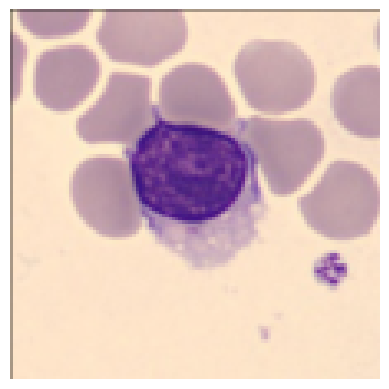

In [42]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming this is the input size for your autoencoder
    transforms.ToTensor(),
])

# Instantiate the dataset
dataset = ImagesDataset(root_dir='/content/drive/MyDrive/MVA/DLMI/dlmi-lymphocytosis-classification/trainset', transform=transform)
valid_size = 0.2  # Pour une division 80% train, 20% valid

# Calculez les tailles des ensembles d'entraînement et de validation
num_samples = len(dataset)
num_valid = int(num_samples * valid_size)
num_train = num_samples - num_valid

# Séparez le jeu de données en sous-ensembles d'entraînement et de validation
dataset_train, dataset_valid = random_split(dataset, [num_train, num_valid])

# Créez les DataLoaders pour les ensembles d'entraînement et de validation
train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=128, shuffle=False)

for sample in train_dataloader:
    #print(sample)
    #print(sample['patient_id'], len(sample['images']))

    #img = sample[0][0]
    print(sample.shape)
    #print(sample[3][0])
    img = sample[0]
    #print(len(img))
    #print(sample[3][1])
    #print(len(sample[0]))
    #print('clinical infos', sample[1])
    #print("label", sample[2])
    img = img.squeeze(0).numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')  # Remove axes for better visual appearance
    plt.show()
    break

In [43]:
# Training of the Autoencoder

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming this is the input size for your autoencoder
    transforms.ToTensor(),
])

# Création de l'instance du modèle
autoencoder = AutoEncoder()

# Mettre le modèle sur le bon appareil (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
num_epochs = 100


best_val_loss=10000

# Training loop (simplified for clarity)
for epoch in range(num_epochs):
    for iter, images in tqdm(enumerate(train_dataloader)):
        images = images.to(device)  # Ensure images are on the correct device

        optimizer.zero_grad()
        output = autoencoder(images)[0]  # Adjust based on your model's return values
        #print(output.shape)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    if epoch %10==0:
      val_loss = 0.0
      with torch.no_grad():  # Pas besoin de calculer les gradients pour la validation
            for images in valid_dataloader:
                images = images.to(device)
                output = autoencoder(images)[0]
                loss = criterion(output, images)
                val_loss += loss.item()
      val_loss /= len(valid_dataloader)

      if val_loss < best_val_loss:
            print(f'Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model ...')
            best_val_loss = val_loss
            torch.save(autoencoder.state_dict(), f"/content/drive/MyDrive/MVA/DLMI/model{epoch}.pt")



0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 3, 112, 112])) that is different to the input size (torch.Size([3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
84it [1:08:06, 47.92s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11, 3, 112, 112])) that is different to the input size (torch.Size([3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
85it [1:08:10, 48.13s/it]


Epoch [1/100], Loss: 0.3761


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 3, 112, 112])) that is different to the input size (torch.Size([3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss decreased (10000.0000 --> 0.3648). Saving model ...


85it [00:40,  2.09it/s]


Epoch [2/100], Loss: 0.2846


85it [00:40,  2.11it/s]


Epoch [3/100], Loss: 0.2376


85it [00:39,  2.13it/s]


Epoch [4/100], Loss: 0.2060


85it [00:39,  2.14it/s]


Epoch [5/100], Loss: 0.1822


85it [00:39,  2.14it/s]


Epoch [6/100], Loss: 0.1553


85it [00:39,  2.14it/s]


Epoch [7/100], Loss: 0.1413


85it [00:39,  2.16it/s]


Epoch [8/100], Loss: 0.1333


85it [00:39,  2.17it/s]


Epoch [9/100], Loss: 0.1197


85it [00:39,  2.15it/s]


Epoch [10/100], Loss: 0.1189


85it [00:39,  2.16it/s]


Epoch [11/100], Loss: 0.1100
Validation loss decreased (0.3648 --> 0.1107). Saving model ...


85it [00:39,  2.13it/s]


Epoch [12/100], Loss: 0.1056


85it [00:39,  2.14it/s]


Epoch [13/100], Loss: 0.0963


85it [00:39,  2.14it/s]


Epoch [14/100], Loss: 0.0979


85it [00:39,  2.16it/s]


Epoch [15/100], Loss: 0.0918


85it [00:39,  2.16it/s]


Epoch [16/100], Loss: 0.0908


85it [00:39,  2.15it/s]


Epoch [17/100], Loss: 0.0923


85it [00:40,  2.08it/s]


Epoch [18/100], Loss: 0.0824


85it [00:39,  2.15it/s]


Epoch [19/100], Loss: 0.0810


85it [00:39,  2.14it/s]


Epoch [20/100], Loss: 0.0858


85it [00:41,  2.03it/s]


Epoch [21/100], Loss: 0.0778
Validation loss decreased (0.1107 --> 0.0793). Saving model ...


85it [00:39,  2.16it/s]


Epoch [22/100], Loss: 0.0763


85it [00:40,  2.11it/s]


Epoch [23/100], Loss: 0.0726


85it [00:40,  2.08it/s]


Epoch [24/100], Loss: 0.0729


85it [00:39,  2.14it/s]


Epoch [25/100], Loss: 0.0701


85it [00:39,  2.15it/s]


Epoch [26/100], Loss: 0.0679


85it [00:40,  2.10it/s]


Epoch [27/100], Loss: 0.0678


85it [00:39,  2.15it/s]


Epoch [28/100], Loss: 0.0658


85it [00:40,  2.09it/s]


Epoch [29/100], Loss: 0.0669


85it [00:40,  2.11it/s]


Epoch [30/100], Loss: 0.0648


85it [00:39,  2.13it/s]


Epoch [31/100], Loss: 0.0616
Validation loss decreased (0.0793 --> 0.0639). Saving model ...


85it [00:39,  2.14it/s]


Epoch [32/100], Loss: 0.0598


85it [00:40,  2.12it/s]


Epoch [33/100], Loss: 0.0632


85it [00:40,  2.12it/s]


Epoch [34/100], Loss: 0.0571


85it [00:40,  2.07it/s]


Epoch [35/100], Loss: 0.0565


85it [00:41,  2.05it/s]


Epoch [36/100], Loss: 0.0538


56it [00:27,  2.05it/s]


KeyboardInterrupt: 

In [86]:
'''
Attention based MIL
'''
class Aggregation_attention(nn.Module):
    def __init__(self):
        super(Aggregation_attention, self).__init__()
        self.M = 60
        self.L = 128
        self.ATTENTION_BRANCHES = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.M),
            nn.ReLU(),
        )

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid()
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 1),
            nn.Sigmoid()
        )

    def forward(self, H):
        '''
        H must be size batch_size * emb_dim
        '''
        #x = x.squeeze(0)

        #H = self.feature_extractor_part1(x)
        #H = H.view(-1, 50 * 4 * 4)
        #H = self.feature_extractor_part2(H)  # KxM

        A_V = self.attention_V(H)  # KxL
        A_U = self.attention_U(H)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K
        #print(A.shape)
        #print(H.shape)
        Z = torch.mm(A, H)  # ATTENTION_BRANCHESxM

        #Y_prob = self.classifier(Z)
        #Y_hat = torch.ge(Y_prob, 0.5).float()

        return Z



In [45]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  
        self.fc2 = nn.Linear(128, 64)  
        self.fc3 = nn.Linear(64, 1)   

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))  
        return x

In [98]:
class Final_Model(nn.Module):
    def __init__(self, encoder, bag_aggregator, classifier):
        super(Final_Model, self).__init__()
        self.encoder = encoder
        self.bag_aggregator = bag_aggregator

        self.classifier = classifier

    def forward(self, list_images, feats):
        batch_features = []
        for patient_images in list_images:
            patient_features = []
            for image in patient_images:
                image = image.to(device)
                output = self.encoder(image.unsqueeze(0))[0]
                patient_features.append(output)
            # Aggregate features for each patient, e.g., by averaging
            #print(torch.stack(patient_features, dim=0).squeeze(1).shape)
            patient_features = self.bag_aggregator(torch.stack(patient_features, dim=0).squeeze(1))
            batch_features.append(patient_features)
        batch_features_tensor = torch.stack(batch_features)
        #print("batch feature", batch_features_tensor.shape)
        #print(feats.shape)
        #if type(x)==tuple:
         #   x = x[0]

        # Size : (batch size, embedding dimension)
        #p = self.bag_aggregator(x)
        # Size : (batch size, 1 or embedding dimension)
        if feats is not None:
            # Concatenate additional features
            p = torch.cat((batch_features_tensor.squeeze(1), feats), 1)
            # Size : (batch size, 1 + features dim or embedding dimension + features dim)
        #print('p', p.shape)
        out = self.classifier(p)
        # Size : (1, num classes)
        return out

In [ ]:
device = "cuda"
# Model, Optimizer, and Loss
state_dict = torch.load('/content/drive/MyDrive/MVA/DLMI/model30.pt')
#encoder = torch.load('/kaggle/working/second_model.pt')
encoder = Encoder()
encoder_state_dict = {k.partition('encoder.')[2]: v for k, v in state_dict.items() if k.startswith('encoder.')}

# Charger les paramètres filtrés dans l'encodeur
encoder.load_state_dict(encoder_state_dict)
#encoder.load_state_dict(etat_modele)
bag_aggregator = Aggregation_attention()
classifier = BinaryClassifier(input_size = 63)
model = Final_Model(encoder, bag_aggregator, classifier)
#class_weights = compute_class_weight('balanced', classes, train_dataset.labels)
#class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Modify the loss function to incorporate class weights
#criterion = nn.CrossEntropyLoss(weight=class_weights)
#weights = torch.tensor([0.4]).to(device)
criterion = nn.BCELoss()
#etat_modele = torch.load('/kaggle/working/second_model.pt')
#model = torch.load('/kaggle/working/second_model.pt')
# Appliquer l'état chargé au modèle
#model.load_state_dict(etat_modele)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0005)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=96000, gamma=0.1)
#etat_modele = torch.load('/kaggle/working/second_model.pt')

#model = torch.load('/kaggle/working/second_model.pt')
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Training Loop
num_epochs = 500
iteration = 0
best_val_loss = float('inf')
best_accu = 0
i=0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader_train:
      #print("new batch")
        images, clinical_data, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()


        # Forward pass
        outputs = model(images, clinical_data.to(device))
      #print("outputs", outputs)


        # Calculate loss
        loss = criterion(outputs, labels.view(-1, 1).type_as(outputs))  # Reshape and cast labels

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
      #print("loss", loss)

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    torch.save(model.state_dict(), "second_epochs_model.pt")
    if (epoch) % 10 == 0:  # Every 10 epochs
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in dataloader_valid:
                images, clinical_data, labels = batch
                #images = images.to(device)
                #clinical_data = clinical_data.to(device)
                #labels = labels.to(device)

                outputs = model(images, clinical_data.to(device))
                preds = (outputs).round()  # Get binary predictions

                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())

        # Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        if balanced_acc > best_accu:
            best_accu = balanced_acc
            nom_modele = "modele_{}.pt".format(i)
            i+=1
            torch.save(model.state_dict(), nom_modele)

        accuracy = accuracy_score(all_labels, all_preds)
        print(classification_report(all_labels, all_preds))
        print(f'Balanced Accuracy on Validation Set: {balanced_acc:.4f}')
        print(f'Accuracy on Validation Set: {accuracy:.4f}')

cuda
Epoch [1/500], Loss: 0.4160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.62      1.00      0.77        20

    accuracy                           0.62        32
   macro avg       0.31      0.50      0.38        32
weighted avg       0.39      0.62      0.48        32

Balanced Accuracy on Validation Set: 0.5000
Accuracy on Validation Set: 0.6250


In [ ]:

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in dataloader_valid:
        images, clinical_data, labels = batch
                #images = images.to(device)
                #clinical_data = clinical_data.to(device)
                #labels = labels.to(device)

        outputs = model(images, clinical_data.to(device))
        preds = torch.sigmoid(outputs).round()  # Get binary predictions

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

        # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))
    print(f'Balanced Accuracy on Validation Set: {balanced_acc:.4f}')
    print(f'Accuracy on Validation Set: {accuracy:.4f}')

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         9
         1.0       1.00      0.74      0.85        23

    accuracy                           0.81        32
   macro avg       0.80      0.87      0.80        32
weighted avg       0.89      0.81      0.82        32

Balanced Accuracy on Validation Set: 0.8696
Accuracy on Validation Set: 0.8125


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in dataloader_test:
        images, clinical_data, labels = batch
                #images = images.to(device)
                #clinical_data = clinical_data.to(device)
                #labels = labels.to(device)

        outputs = model(images, clinical_data.to(device))
        preds = torch.sigmoid(outputs).round()  # Get binary predictions

        all_preds.extend(preds.view(-1).cpu().numpy())
        #all_labels.extend(labels.view(-1).cpu().numpy())

        # Calculate balanced accuracy


In [ ]:
all_preds

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
submission = pd.read_csv("/kaggle/input/dlmi-datachallenge/dlmi-lymphocytosis-classification-2/sample_submission.csv")
submission.head()

,ID,LABEL
0,P9,0
1,P172,1
2,P57,0
3,P16,0
4,P203,0


In [ ]:
test_soumission = pd.read_csv("/kaggle/input/dlmi-datachallenge/dlmi-lymphocytosis-classification-2/clinical_annotation.csv", index_col=0)
test_soumission = test_soumission[test_soumission['LABEL'] == -1]

In [ ]:
test_soumission

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
6,P71,-1,M,1/17/1946,5.76
9,P16,-1,M,3/5/1940,32.00
12,P114,-1,M,6/16/1929,4.60
15,P170,-1,M,11/3/1933,4.80
18,P98,-1,F,5/14/1970,6.24
23,P69,-1,M,4/4/1979,7.47
29,P92,-1,F,3/21/1947,55.26
30,P132,-1,M,8/24/1945,24.70
31,P81,-1,M,11/22/1958,64.86
41,P73,-1,F,6/21/1923,4.28


In [ ]:
test_soumission['Predicted'] = np.array(all_preds)
test_soumission['Predicted'] = test_soumission['Predicted'].astype(int)

In [ ]:
test_soumission = test_soumission.drop(['GENDER', 'LYMPH_COUNT', 'DOB'], axis=1)
test_soumission.head()

,ID,LABEL,Predicted
6,P71,-1,0
9,P16,-1,1
12,P114,-1,1
15,P170,-1,0
18,P98,-1,0


In [ ]:
test_soumission.drop(['LABEL'], axis=1, inplace=True)

In [ ]:
test_soumission.to_csv('third500epochs_submit.csv', index=False)

In [ ]:
test_soumission.reset_index(drop=True, inplace=True)
test_soumission.rename({'ID':'Id'},axis=1, inplace=True)
test_soumission
test_soumission.head()

,Id,Predicted
0,P71,0
1,P16,1
2,P114,1
3,P170,0
4,P98,0
